In [88]:
# import dependencies
import IPython
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
import dlib
import numpy as np
import imutils

In [89]:
from IPython.display import display, Javascript, Image,Audio
from base64 import b64decode, b64encode
from imutils.face_utils.helpers import FACIAL_LANDMARKS_68_IDXS
from imutils.face_utils.helpers import FACIAL_LANDMARKS_5_IDXS
from imutils.face_utils.helpers import shape_to_np
from imutils import face_utils
from imutils.face_utils import *
from scipy.spatial import distance as dist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image
import base64
from dlib import *


In [90]:
# Play an audio beep. Any audio URL will do.
alert='new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()'
bienvenue='new Audio("https://upload.wikimedia.org/wikipedia/commons/1/1a/Bienvenue-chez-votre-applicati1651880044.ogg").play()'
pause='new Audio("https://upload.wikimedia.org/wikipedia/commons/7/7e/Penser-a-prendre-une-petite-pa1651880436.ogg").play()'
reveil='new Audio("https://upload.wikimedia.org/wikipedia/commons/2/23/R%C3%A9veillez-vousr%C3%A9veillez-vous-1651880280_%281%29.ogg").play()'


In [91]:
model=load_model(r"C:\Users\User\Memoire\Somnolence-Detection-Project--main\model\Somnolance_Detection_new.h5")
figure = plt.figure(figsize=(5, 5))
face_cascade = cv2.CascadeClassifier(r'C:\Users\User\Memoire\Somnolence-Detection-Project--main\Hardcascad_file\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'C:\Users\User\Memoire\Somnolence-Detection-Project--main\Hardcascad_file\haarcascade_eye.xml')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r'C:\Users\User\Memoire\Driver-distraction-detection-master\data\shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [92]:
def calculate_lip(lips):
     dist1 = dist.euclidean(lips[2], lips[6]) 
     dist2 = dist.euclidean(lips[0], lips[4]) 

     LAR = float(dist1/dist2)

     return LAR


In [93]:
def js_to_image(js_reply):
    """
    Params:
        js_reply: Objet JavaScript contenant l'image de la webcam
    Returns:
        img: Image OpenCV au format BGR
    """
    # Décoder l'image en base64
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convertir les octets en tableau numpy
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Décoder le tableau numpy en image OpenCV au format BGR
    img = cv2.imdecode(jpg_as_np, flags=cv2.IMREAD_COLOR)

    return img

# Fonction pour convertir une image de boîte englobante OpenCV en chaîne d'octets base64 à superposer sur le flux vidéo
def bbox_to_bytes(bbox_array):
    """
    Params:
        bbox_array: Tableau Numpy (pixels) contenant le rectangle à superposer sur le flux vidéo.
    Returns:
        bytes: Chaîne d'octets d'image en base64
    """
    # Convertir le tableau en image PIL
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    # Enregistrer le bbox au format PNG dans le tampon
    bbox_PIL.save(iobuf, format='PNG')
    # Formater la chaîne de retour
    bbox_bytes = 'data:image/png;base64,{}'.format(b64encode(iobuf.getvalue()).decode('utf-8'))

    return bbox_bytes

In [94]:
# JavaScript pour créer correctement notre flux vidéo en direct en utilisant la webcam comme entrée
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
        stream.getVideoTracks()[0].stop();
        video.remove();
        div.remove();
        video = null;
        div = null;
        stream = null;
        imgElement = null;
        captureCanvas = null;
        labelElement = null;
    }
    
    function onAnimationFrame() {
        if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
        }
        if (pendingResolve) {
            var result = "";
            if (!shutdown) {
                captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                result = captureCanvas.toDataURL('image/jpeg', 0.8);
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
        }
    }
    
    async function createDom() {
        if (div !== null) {
            return stream;
        }

        div = document.createElement('div');
        div.style.border = '2px solid black';
        div.style.padding = '3px';
        div.style.width = '100%';
        div.style.maxWidth = '600px';
        document.body.appendChild(div);
        
        const modelOut = document.createElement('div');
        modelOut.innerHTML = "<span>Status:</span>";
        labelElement = document.createElement('span');
        labelElement.innerText = 'No data';
        labelElement.style.fontWeight = 'bold';
        modelOut.appendChild(labelElement);
        div.appendChild(modelOut);
        
        video = document.createElement('video');
        video.style.display = 'block';
        video.width = div.clientWidth - 6;
        video.setAttribute('playsinline', '');
        video.onclick = () => { shutdown = true; };
        
        // Demander l'accès à la webcam
        stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment" }});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.position = 'absolute';
        imgElement.style.zIndex = 1;
        imgElement.onclick = () => { shutdown = true; };
        div.appendChild(imgElement);
        
        const instruction = document.createElement('div');
        instruction.innerHTML = 
            '<span style="color: red; font-weight: bold;">' +
            'When finished, click here or on the video to stop this demo</span>';
        div.appendChild(instruction);
        instruction.onclick = () => { shutdown = true; };
        
        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640; // video.videoWidth;
        captureCanvas.height = 480; // video.videoHeight;
        window.requestAnimationFrame(onAnimationFrame);
        
        return stream;
    }

    async function stream_frame(label, imgData) {
        if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
        }

        var preCreate = Date.now();
        stream = await createDom();
        
        var preShow = Date.now();
        if (label != "") {
            labelElement.innerHTML = label;
        }
        
        if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
        }
        
        var preCapture = Date.now();
        var result = await new Promise(function(resolve) {
            pendingResolve = resolve;
        });
        shutdown = false;
        
        return {
            'create': preShow - preCreate, 
            'show': preCapture - preShow, 
            'capture': Date.now() - preCapture,
            'img': result
        };
    }
    ''')

    display(js)
  
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data


Evaluating JS: stream_frame("Capturing...", "")
{'img': ''}

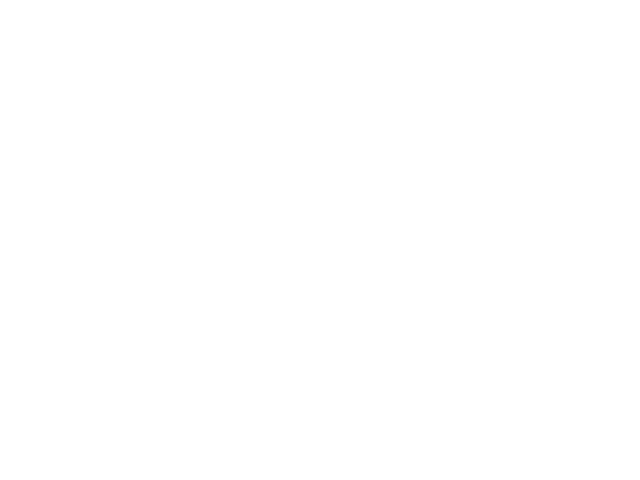

RuntimeError: Unsupported image type, must be 8bit gray or RGB image.

In [95]:


# Fonction pour générer une image simulée
def generate_dummy_image():
    img = np.ones((480, 640, 3), dtype=np.uint8) * 255  # Image blanche
    _, buffer = cv2.imencode('.png', img)
    return base64.b64encode(buffer).decode('utf-8')

# Fonction d'évaluation JS
def eval_js(js_code): 
    print(f"Evaluating JS: {js_code}")
    return {"img": f"data:image/png;base64,{generate_dummy_image()}"}

# Définition de la fonction video_frame
def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Initialiser l'objet output
class Output:
    def eval_js(self, js_code):
        print(f"Evaluating JS: {js_code}")

output = Output()

# Initialisation des détecteurs
detector = dlib.get_frontal_face_detector()
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

# Étiquette pour la vidéo
label_html = 'Capturing...'
bbox = ''
counter = 0
lip_LAR = 0.4
lip_per_frame = 1

while True:
    # Récupérer la réponse du flux vidéo
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Vérifiez le contenu de js_reply
    print(js_reply)  # Pour déboguer

    # Convertir la réponse JS en image OpenCV
    if isinstance(js_reply, dict) and "img" in js_reply:
        img_data = js_reply["img"]
        if img_data.startswith('data:image/') and ',' in img_data:
            image_bytes = base64.b64decode(img_data.split(',')[1])
            img = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            raise ValueError("Image data format is incorrect.")
    else:
        raise ValueError("Invalid js_reply structure.")

    # Initialiser bbox_array
    bbox_array = np.zeros((480, 640, 4), dtype=np.uint8)

    # Détection des visages
    rects = detector(gray, 2)
    faces = detector(gray)

    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        faceAligned = fa.align(img, gray, rect)
        faceAligned_gray = cv2.cvtColor(faceAligned, cv2.COLOR_BGR2GRAY)

        plt.imshow(faceAligned_gray)
        plt.axis('off')
        plt.title('Aligned Face')

        # Détection des yeux
        eyes = eye_cascade.detectMultiScale(faceAligned_gray, 1.1, 4)
        predictions = []

        for (ex, ey, ew, eh) in eyes:
            eye = faceAligned[ey:ey + eh, ex:ex + ew]
            eye = cv2.resize(eye, (32, 32))
            eye = np.expand_dims(np.array(eye), axis=0)

            # Prédiction
            ypred = model.predict(eye)
            ypred = np.argmax(ypred[0], axis=0)
            predictions.append(ypred)

            # Vérification de l'état de sommeil
            if all(i == 0 for i in predictions):
                bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 8)
                bbox_array = cv2.putText(bbox_array, 'Sleeping', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)
                output.eval_js(alert)
                output.eval_js(reveil)
            else:
                bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 8)
                bbox_array = cv2.putText(bbox_array, 'Not Sleeping', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
            break

    # Traitement des visages détectés
    for (i, face) in enumerate(faces):
        lips = [60, 61, 62, 63, 64, 65, 66, 67]
        point = predictor(gray, face)
        points = face_utils.shape_to_np(point)
        lip_point = points[lips]
        LAR = calculate_lip(lip_point)

        lip_hull = cv2.convexHull(lip_point)
        cv2.drawContours(bbox_array, [lip_hull], -1, (0, 255, 0), 1)

        # Alerte de bâillement
        if LAR > lip_LAR:
            counter += 1
            if counter > lip_per_frame:
                cv2.putText(bbox_array, "YAWNING ALERT!", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                output.eval_js(pause)
        else:
            counter = 0

    # Affichage du rapport LAR
    cv2.putText(bbox_array, "LAR: {:.2f}".format(LAR), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Mise à jour de la transparence de l'overlay
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Conversion de l'overlay de la boîte englobante en octets
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Mettre à jour la boîte englobante pour le prochain cadre
    bbox = bbox_bytes

    # Afficher l'image
    cv2.imshow('Video Stream', bbox_array)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cv2.destroyAllWindows()
